In [96]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder


## **Co-variance Matrix** 

In [97]:
def rewrite_header_fasta(input_fasta, output_fasta):
    with open(output_fasta, "w") as out_f:
        for i, record in enumerate(SeqIO.parse(input_fasta, "fasta"), start=1):
            record.id = f"seq{i}"
            record.description = ""  # Remove any additional description
            SeqIO.write(record, out_f, "fasta")

    print("Headers updated successfully!")



def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        fasta_dict = {}
        header = None
        for line in infile:
            line = line.strip()  # Remove leading/trailing whitespace (including erroneous newlines)
            if line.startswith(">"):  # New header
                header = line
                fasta_dict[header] = []
            elif header:  # Sequence line
                fasta_dict[header].append(line)

        # Write cleaned FASTA
        for header, seq_list in fasta_dict.items():
            outfile.write(f"{header}\n{''.join(seq_list)}\n")  # Concatenated sequence in one line

def compute_avg_seq_identity(smat):
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    return avg_identity


def plot_avg_seq_identity_histogram(smat, bins=50):
    """ Given a sequence identity matrix, plot a histogram of the average pairwise sequence identity for each sequence. """
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(avg_identity, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Average Pairwise Sequence Identity")
    plt.ylabel("Density")
    plt.title("Histogram of Average Pairwise Sequence Identity")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


In [98]:
arr_seq = readAlignment('data/cleaned_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)


len of sequences: 970
arr_num shape: (970, 2767)
seq shape before filtering: (970, 2767)
seq shape after filtering: (752, 437)


In [99]:
# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_real = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_real.shape)

one hot after filtering: (752, 9177)
identity shape: (752, 752)


In [100]:
# print(one_hot_filtered)

(84, 30)
(84, 84)
[[46.45831465 41.38840417 41.4721292  40.90003056]
 [41.38840417 40.92523671 38.39189368 38.15183482]
 [41.4721292  38.39189368 40.72008104 38.35524736]
 [40.90003056 38.15183482 38.35524736 39.56166073]]


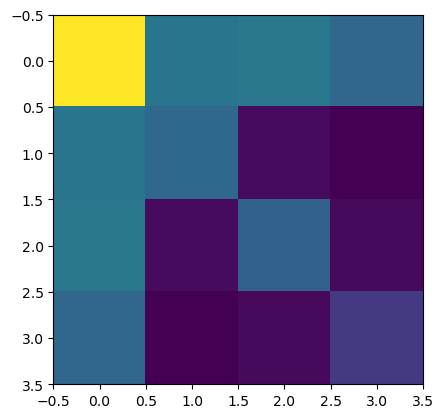

In [101]:

def compute_lxl_cov(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    #S = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    #print(S.shape)

    C = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    print(C.shape)
    
    # Compute mean frequency
    #p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    # print(p.shape)
    
    # Compute covariance matrix
    #C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            C_lxl[i, j] = np.linalg.norm(C_block, ord='fro') #Frobenius norm

    return C_lxl

# Example usage
L = 4  # Sequence length
M = 30  # Number of sequences
np.random.seed(42)
#one_hot_matrix = np.ones((21*L, M))
one_hot_matrix = np.random.randint(0, 2, size=(21*L, M))  # Simulated one-hot encoding
print(one_hot_matrix.shape)
C_lxl = compute_lxl_cov(one_hot_matrix, L)
print(C_lxl)
plt.imshow(C_lxl)

In [102]:
print('one hot after filtering:', one_hot_filtered.shape)
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered.shape[1]/21)
C_lxl_cov_real = compute_lxl_cov(one_hot_filtered_np.T, L)


one hot after filtering: (752, 9177)
(9177, 9177)


Text(0.5, 1.0, 'Serotonin pathway proteins (PDB)')

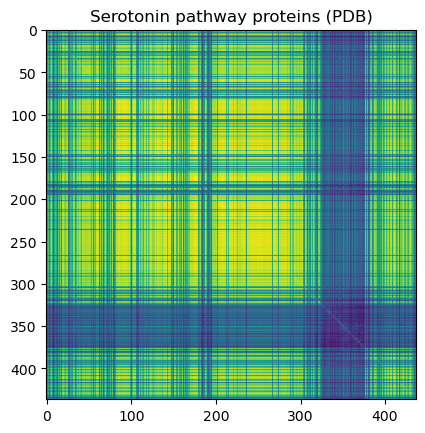

In [103]:
plt.imshow(C_lxl_cov_real)
plt.title('Serotonin pathway proteins (PDB)')
# plt.savefig('real_protein_cov.pdf', format='pdf', dpi=300)
# plt.savefig('real_protein_cov.png', dpi=300)

simulated seq

In [104]:
arr_seq = readAlignment('data/cleaned_synthetic_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_mpnn = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_mpnn.shape)

len of sequences: 100
arr_num shape: (100, 399)
seq shape before filtering: (100, 399)
seq shape after filtering: (100, 389)
one hot after filtering: (100, 8169)
identity shape: (100, 100)


one hot after filtering: (100, 8169)
(8169, 8169)


Text(0.5, 1.0, 'Serotonin pathway proteins (ProteinMPNN)')

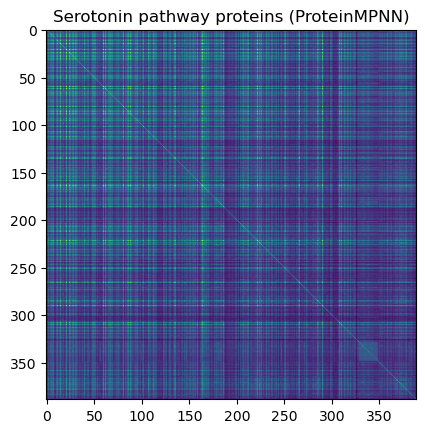

In [105]:
print('one hot after filtering:', one_hot_filtered.shape)
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered_np.shape[1] / 21)
C_lxl_cov_mpnn = compute_lxl_cov(one_hot_filtered_np.T, L)

plt.imshow(C_lxl_cov_mpnn)
plt.title('Serotonin pathway proteins (ProteinMPNN)')
# plt.savefig('mpnn_protein_cov.pdf', format='pdf', dpi=300)
# plt.savefig('mpnn_protein_cov.png', dpi=300)

C_cov_mpnnn_flat shape: (151321,)
C_cov_reak_flat shape: (190969,)


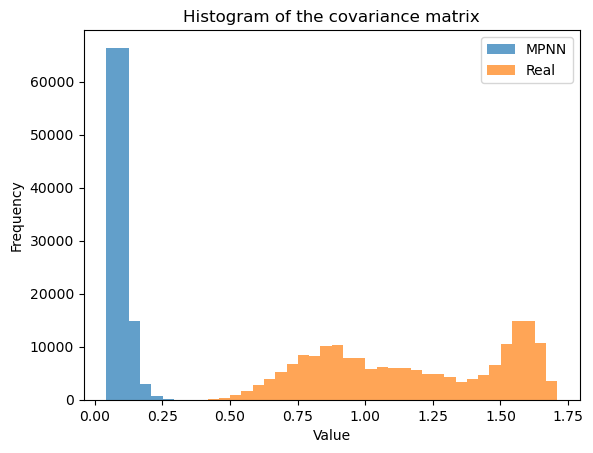

In [ ]:
# histograms
C_cov_mpnnn_flat = C_lxl_cov_mpnn.flatten()
print('C_cov_mpnnn_flat shape:', C_cov_mpnnn_flat.shape)
C_cov_real_flat = C_lxl_cov_real.flatten()
print('C_cov_reak_flat shape:', C_cov_real_flat.shape)

plt.hist([C_cov_mpnnn_flat, C_cov_real_flat], bins=40, stacked=True, label=['MPNN', 'Real'], alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the covariance matrix')
plt.legend()

# plt.savefig('hist_cov_mat.png', dpi=300)
plt.show()

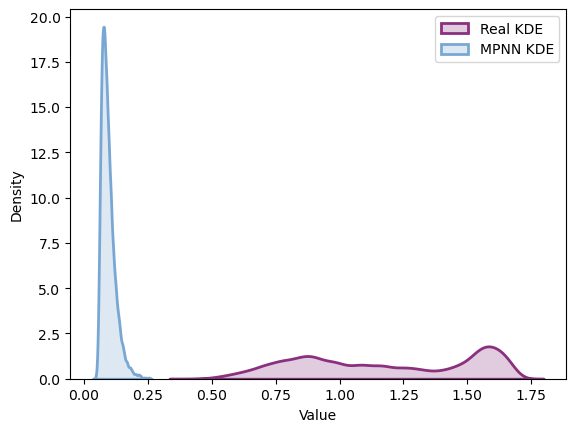

In [ ]:
sns.kdeplot(C_cov_real_flat, label='Real KDE', color='#8a307f', linewidth=2, fill=True)
sns.kdeplot(C_cov_mpnnn_flat, label='MPNN KDE', color='#79a7d3', linewidth=2, fill=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# plt.savefig('kde_cov_mat.png', dpi=300)

## **Mutual information**

(84, 30)
(84, 84)
[[0.16050618 0.17003133 0.20847112 0.17964199]
 [0.24986201 0.         0.07935064 0.        ]
 [0.17244985 0.         0.07150486 0.13694166]
 [0.34862376 0.06618034 0.         0.04430448]]


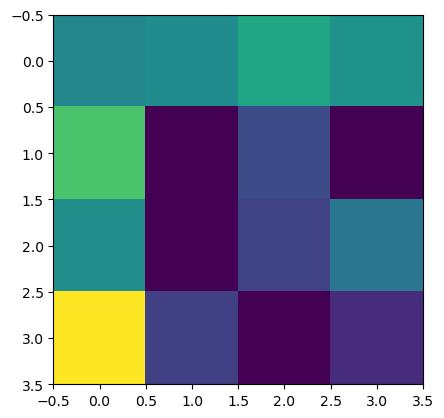

In [35]:
def compute_lxl_mi(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    #S = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    #print(S.shape)

    C = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    print(C.shape)
    
    # Compute mean frequency
    #p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    # print(p.shape)
    
    # Compute covariance matrix
    #C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            mi = mutual_info_regression(np.ravel(C_block[0]).reshape(-1, 1), np.ravel(C_block[1].reshape(-1, 1)), discrete_features=[False]) #mutual info score
            C_lxl[i, j] = mi[0]

    return C_lxl

# Example usage
L = 4  # Sequence length
M = 30  # Number of sequences
np.random.seed(42)
#one_hot_matrix = np.ones((21*L, M))
one_hot_matrix = np.random.randint(0, 2, size=(21*L, M))  # Simulated one-hot encoding
print(one_hot_matrix.shape)
C_lxl = compute_lxl_mi(one_hot_matrix, L)
print(C_lxl)
plt.imshow(C_lxl)

In [36]:
arr_seq = readAlignment('data/cleaned_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

len of sequences: 970
arr_num shape: (970, 2767)
seq shape before filtering: (970, 2767)
seq shape after filtering: (752, 437)


In [37]:
# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_real = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_real.shape)

one hot after filtering: (752, 9177)
identity shape: (752, 752)


(9177, 9177)


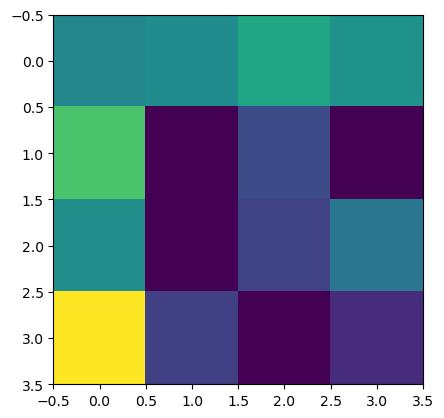

In [38]:
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered.shape[1]/21)
C_lxl_real = compute_lxl_mi(one_hot_filtered_np.T, L)
plt.imshow(C_lxl)

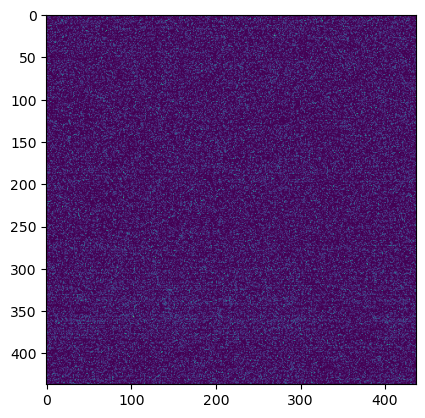

In [42]:
plt.imshow(C_lxl_real)

len of sequences: 100
arr_num shape: (100, 399)
seq shape before filtering: (100, 399)
seq shape after filtering: (100, 389)
one hot after filtering: (100, 8169)
identity shape: (100, 100)
one hot after filtering: (100, 8169)
(8169, 8169)


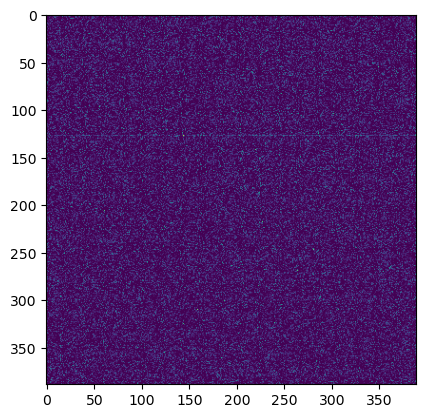

In [39]:
arr_seq = readAlignment('data/cleaned_synthetic_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_mpnn = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_mpnn.shape)

print('one hot after filtering:', one_hot_filtered.shape)
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered_np.shape[1] / 21)
C_lxl_mpnn = compute_lxl_mi(one_hot_filtered_np.T, L)

plt.imshow(C_lxl_mpnn)

flat matrix shape: (151321,)
flat matrix shape: (190969,)


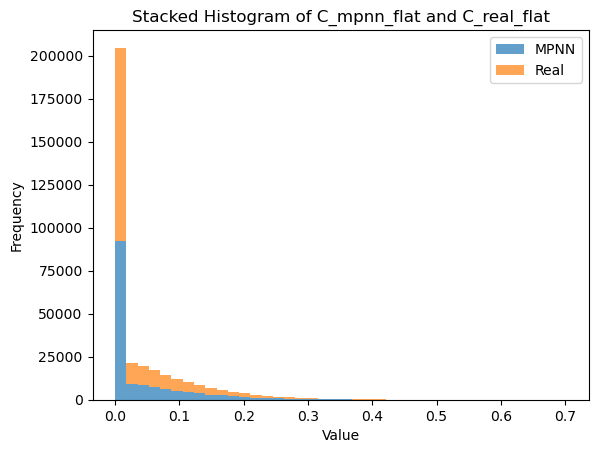

In [47]:
C_mpnn_flat = C_lxl_mpnn.flatten()
print('flat matrix shape:', C_mpnn_flat.shape)
C_real_flat = C_lxl_real.flatten()
print('flat matrix shape:', C_real_flat.shape)

plt.hist([C_mpnn_flat, C_real_flat], bins=40, stacked=True, label=['MPNN', 'Real'], alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of C_mpnn_flat and C_real_flat')
plt.legend()
plt.show()

In [52]:
C_mpnn_flat[C_mpnn_flat>0.5]

array([0.50200028, 0.51496337, 0.55976738, 0.6052484 , 0.50945374,
       0.50910838, 0.58098248, 0.52035355, 0.53753624, 0.51174087,
       0.69841292, 0.51286352, 0.66088227, 0.59224198, 0.54575328,
       0.58109136, 0.5119628 , 0.69441671, 0.51903072, 0.65455956,
       0.51906159, 0.58519136, 0.58188668, 0.58499004, 0.53761849,
       0.57958996, 0.70110354, 0.50417178, 0.57295552, 0.54204953,
       0.59945394, 0.58457683, 0.51508085, 0.5629038 , 0.52995011,
       0.52033028])

flat matrix shape: (63519,)
flat matrix shape: (83968,)


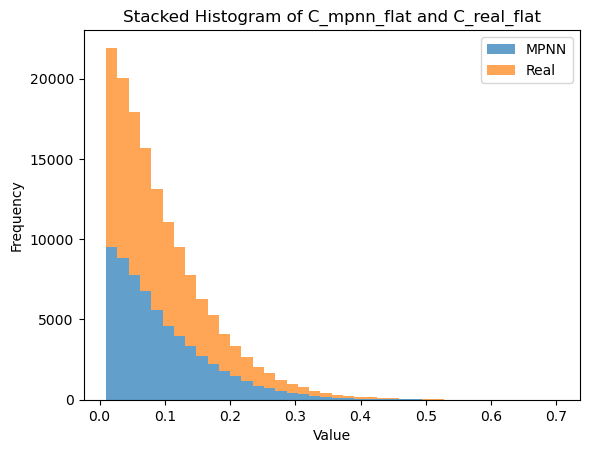

In [65]:
C_mpnn_large_mi_flat = C_mpnn_flat[C_mpnn_flat>0.01]
print('flat matrix shape:', C_mpnn_large_mi_flat.shape)
C_real_large_mi_flat = C_real_flat[C_real_flat>0.01]
print('flat matrix shape:', C_real_large_mi_flat.shape)

plt.hist([C_mpnn_large_mi_flat, C_real_large_mi_flat], bins=40, stacked=True, label=['MPNN', 'Real'], alpha=0.7)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of C_mpnn_flat and C_real_flat')
plt.legend()
plt.show()

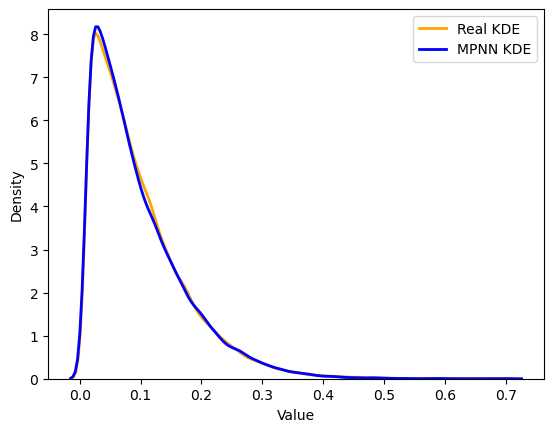

In [64]:
sns.kdeplot(C_real_large_mi_flat, label='Real KDE', color='orange', linewidth=2)
sns.kdeplot(C_mpnn_large_mi_flat, label='MPNN KDE', color='blue', linewidth=2)

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
